# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

Image augmentation in [Keras](https://keras.io/preprocessing/image/).

### 1. Load CIFAR-10 Database

In [2]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2. Visualize the First 24 Training Images

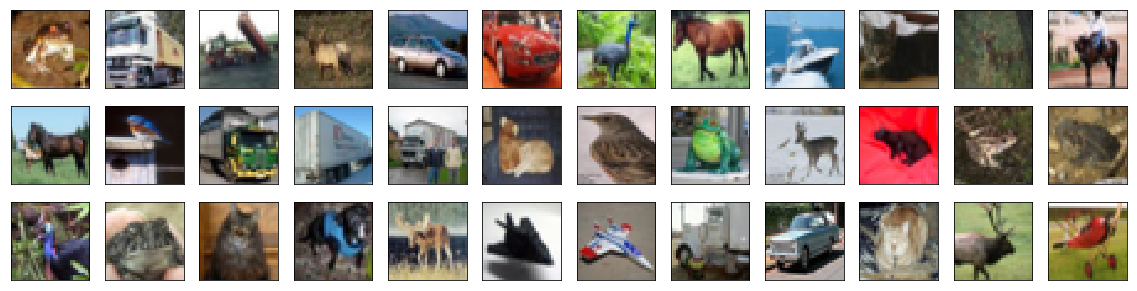

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [4]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [5]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

Feel free to modify this part to use different setting for data [augmentation](https://keras.io/preprocessing/image/).

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)

### 6. Visualize Original and Augmented Images

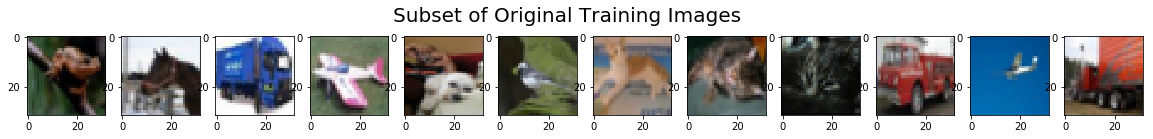

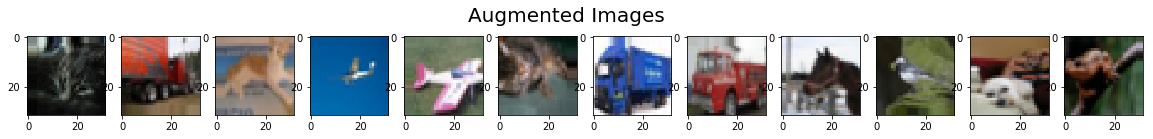

In [7]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12): #note the flow function
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)          0         
__________

### 8. Compile the Model 

In [11]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model 

Since we are working with augmented data, the commands here a little different from the ones in `cifar10_cnn.ipynb`.

- `fit` has been changed to `fit.generator`: note we are fitting our CNN augmented images that are being generated by the `ImageDataGenerator` class.
- instead of the training data, we have the `flow`command that has been executed on out training set. It makes the data generator create batches of augmented images (one of these batches was visualized in the section 6).
- `steps_per_epoch`: specifies the number of steps per epoch.

In [12]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.35247, saving model to aug_model.weights.best.hdf5
 - 32s - loss: 1.7045 - acc: 0.3862 - val_loss: 1.3525 - val_acc: 0.5250
Epoch 2/100
Epoch 00002: val_loss improved from 1.35247 to 1.16412, saving model to aug_model.weights.best.hdf5
 - 38s - loss: 1.3997 - acc: 0.4977 - val_loss: 1.1641 - val_acc: 0.5952
Epoch 3/100
Epoch 00003: val_loss improved from 1.16412 to 1.08150, saving model to aug_model.weights.best.hdf5
 - 35s - loss: 1.2763 - acc: 0.5473 - val_loss: 1.0815 - val_acc: 0.6200
Epoch 4/100
Epoch 00004: val_loss improved from 1.08150 to 0.99786, saving model to aug_model.weights.best.hdf5
 - 36s - loss: 1.2096 - acc: 0.5708 - val_loss: 0.9979 - val_acc: 0.6602
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 38s - loss: 1.1679 - acc: 0.5912 - val_loss: 1.0252 - val_acc: 0.6554
Epoch 6/100
Epoch 00006: val_loss improved from 0.99786 to 0.97579, saving model to aug_model.weights.best.hdf5
 - 35s - loss: 1.1448 - acc: 

Epoch 65/100
Epoch 00065: val_loss did not improve
 - 36s - loss: 1.7165 - acc: 0.4137 - val_loss: 1.2599 - val_acc: 0.5778
Epoch 66/100
Epoch 00066: val_loss did not improve
 - 35s - loss: 1.7117 - acc: 0.4161 - val_loss: 1.5048 - val_acc: 0.4800
Epoch 67/100
Epoch 00067: val_loss did not improve
 - 35s - loss: 1.7223 - acc: 0.4141 - val_loss: 1.4328 - val_acc: 0.4926
Epoch 68/100
Epoch 00068: val_loss did not improve
 - 36s - loss: 1.7163 - acc: 0.4181 - val_loss: 1.4384 - val_acc: 0.4838
Epoch 69/100
Epoch 00069: val_loss did not improve
 - 35s - loss: 1.7147 - acc: 0.4166 - val_loss: 1.5780 - val_acc: 0.3938
Epoch 70/100
Epoch 00070: val_loss did not improve
 - 35s - loss: 1.7358 - acc: 0.4095 - val_loss: 1.3292 - val_acc: 0.5218
Epoch 71/100
Epoch 00071: val_loss did not improve
 - 34s - loss: 1.7243 - acc: 0.4103 - val_loss: 1.3778 - val_acc: 0.5172
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 35s - loss: 1.7169 - acc: 0.4095 - val_loss: 1.5799 - val_acc: 0.4320
Epoch 73

### 10. Load the Model with the Best Validation Accuracy

In [14]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

There is a slight improvement over the model we trained without augmentation in `cifar10_cnn.ipynb`. In fact, augmentation is used extensively in real world applications to boost the performance of CNN models.

In [15]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6794


### Groundbreaking CNN Architectures: Optional Resources


- Check out the [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) paper!
- Read more about [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) here.
- The [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf) paper can be found here.
- Here's the Keras [documentation](https://keras.io/applications/) for accessing some famous CNN architectures.
- Read this [detailed treatment](http://neuralnetworksanddeeplearning.com/chap5.html) of the vanishing gradients problem.
- Here's a GitHub [repository](https://github.com/jcjohnson/cnn-benchmarks) containing benchmarks for different CNN architectures.
- Visit the [ImageNet Large Scale Visual Recognition Competition (ILSVRC)](http://www.image-net.org/challenges/LSVRC/) website.

## Visualizing CNNs


Let us look at an example CNN to see how it works in action.

The CNN we will look at is trained on ImageNet as described in [this paper](http://www.matthewzeiler.com/pubs/arxive2013/eccv2014.pdf) by Zeiler and Fergus. In the images below (from the same paper), we will see what each layer in this network detects and see how each layer detects more and more complex ideas.

### First layer

Below example patterns that cause activations in the first layer of the network. These range from simple diagonal lines (top left) to green blobs (bottom middle).

<img src='../conv-visualization/images/layer-1-grid.png'>

The images above are from Matthew Zeiler and Rob Fergus' [deep visualization toolbox](https://www.youtube.com/watch?v=ghEmQSxT6tw), which lets us visualize what each layer in a CNN focuses on.

Each image in the above grid represents a pattern that causes the neurons in the first layer to activate - in other words, they are patterns that the first layer recognizes. The top left image shows a -45 degree line, while the middle top square shows a +45 degree line. These squares are shown below again for reference.

As visualized here, the first layer of the CNN can recognize -45 degree lines:

<img src='../conv-visualization/images/diagonal-line-1.png'>

The first layer of the CNN is also able to recognize +45 degree lines, like the one above:

<img src='../conv-visualization/images/diagonal-line-2.png'>

Let us now see some example images that cause such activations. The below grid of images all activated the -45 degree line. Notice how they are all selected despite the fact that they have different colors, gradients, and patterns.

Example patches that activate the -45 degree line detector in the first layer:

<img src='../conv-visualization/images/grid-layer-1.png'>

So, the first layer of our CNN clearly picks out very simple shapes and patterns like lines and blobs.

### Layer 2

A visualization of the second layer in the CNN. Notice how we are picking up more complex ideas like circles and stripes. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right:

<img src='../conv-visualization/images/screen-shot-2016-11-24-at-12.09.02-pm.png'>

The second layer of the CNN captures complex ideas.

As you see in the image above, the second layer of the CNN recognizes circles (second row, second column), stripes (first row, second column), and rectangles (bottom right).

**The CNN learns to do this on its own**. There is no special instruction for the CNN to focus on more complex objects in deeper layers. That is just how it normally works out when you feed training data into a CNN.

### Layer 3

A visualization of the third layer in the CNN. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right:

<img src='../conv-visualization/images/screen-shot-2016-11-24-at-12.09.24-pm.png'>

The third layer picks out complex combinations of features from the second layer. These include things like grids, and honeycombs (top left), wheels (second row, second column), and even faces (third row, third column).

We will skip layer 4, which continues this progression, and jump right to the fifth and final layer of this CNN.

### Layer 5

A visualization of the fifth and final layer of the CNN. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right:

<img src='../conv-visualization/images/screen-shot-2016-11-24-at-12.08.11-pm.png'>

The last layer picks out the highest order ideas that we care about for classification, like dog faces, bird faces, and bicycles.


### Visualizing CNNs: Optional Resources

If you would like to know more about interpreting CNNs and convolutional layers in particular, you are encouraged to check out these resources:

- Here's a [section](http://cs231n.github.io/understanding-cnn/) from the Stanford's CS231n course on visualizing what CNNs learn.
- Check out this [demonstration](https://aiexperiments.withgoogle.com/what-neural-nets-see) of a cool [OpenFrameworks](http://openframeworks.cc/) app that visualizes CNNs in real-time, from user-supplied video!
- Here's a [demonstration](https://www.youtube.com/watch?v=AgkfIQ4IGaM&t=78s) of another visualization tool for CNNs. If you'd like to learn more about how these visualizations are made, check out this [video](https://www.youtube.com/watch?v=ghEmQSxT6tw&t=5s).
- Here's [another visualization tool](https://medium.com/merantix/picasso-a-free-open-source-visualizer-for-cnns-d8ed3a35cfc5) that seamlessly works with CNNs in Keras and Tensorflow.
- Read this [Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) on visualizing how CNNs see the world. In this post, you can find an accessible introduction to Deep Dreams, along with code for writing your own deep dreams in Keras. When you've read that:
    - Also check out this [music video](https://www.youtube.com/watch?v=XatXy6ZhKZw) that makes use of Deep Dreams (look at 3:15-3:40)!
    - Create your own Deep Dreams (without writing any code!) using this [website](https://deepdreamgenerator.com/).



- If you'd like to read more about interpretability of CNNs,
    - here's an [article](https://blog.openai.com/adversarial-example-research/) that details some dangers from using deep learning models (that are not yet interpretable) in real-world applications.
    - there's a lot of active research in this area. [These authors](https://arxiv.org/abs/1611.03530) recently made a step in the right direction.
